# Retrained Autoencoder Model

This model was retrained based on selected features that were used in training the models for streaming. 

In [1]:
# Install and Import Libraries 
%pip install tensorflow joblib

import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Define Paths 
project_root = Path.cwd().parents[0]
data_dir = project_root / "data" / "processed"
model_dir = project_root / "models" / "trained_model"
model_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Load Data and Restore Feature Names 
X = pd.read_csv(data_dir / "X_processed.csv")
y = pd.read_csv(data_dir / "y_processed.csv").squeeze()
full_feature_list = joblib.load(data_dir / "feature_columns.pkl")


# Assign correct column names to X
X.columns = full_feature_list

In [4]:
# Define SHAP-Selected Feature Subset 
selected_features = [
    "TransactionAmt", "TransactionDT",
    "card1", "card4_freq", "card6_freq",
    "addr1", "dist1",
    "P_emaildomain_freq", "R_emaildomain_freq",
    "M1_freq", "M4_freq", "M5_freq", "M6_freq", "M9_freq",
    "C1", "C2", "C8", "C11",
    "V18", "V21", "V97", "V133", "V189", "V200", "V258", "V282", "V294", "V312",
    "DeviceType_freq", "id_15_freq", "id_28_freq", "id_29_freq",
    "id_31_freq", "id_35_freq", "id_36_freq", "id_37_freq", "id_38_freq"
]


# Ensure columns exist (just in case)
selected_features = [f for f in selected_features if f in X.columns]

In [5]:
# Prepare Legitimate Transaction Subset 
X = X[selected_features].reset_index(drop=True)
y = y.reset_index(drop=True)
X_normal = X[y == 0].copy()

In [6]:
# Normalize Legitimate Transactions 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_normal)
joblib.dump(scaler, model_dir / "autoencoder_scaler.pkl")

['c:\\Users\\danar\\OneDrive - The University of the West Indies, St. Augustine\\UWI\\Year 3\\Semester 2\\Big Data\\fraud-detection\\models\\trained_model\\autoencoder_scaler.pkl']

In [7]:
# Define Autoencoder Architecture with Bottleneck Layer
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(64, activation='relu')(input_layer)
bottleneck = Dense(32, activation='relu', name='bottleneck')(encoded)
decoded = Dense(64, activation='relu')(bottleneck)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

In [8]:
# Split and Train Autoencoder 
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, X_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0205 - val_loss: 1.6835e-04
Epoch 2/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2089e-04 - val_loss: 6.6237e-05
Epoch 3/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.6620e-05 - val_loss: 4.5554e-05
Epoch 4/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.1895e-05 - val_loss: 3.3280e-05
Epoch 5/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.1661e-05 - val_loss: 2.8970e-05
Epoch 6/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.7775e-05 - val_loss: 2.5217e-05
Epoch 7/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.3340e-05 - val_loss: 2.0070e-05
Epoch 8/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.0821e-05 - val_loss: 2.0563e-05
Epoch 9/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7615e-05 - val_loss: 1.6774e-05
Epoch 10/100
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6454e-05 - val_loss: 1.3726e-05
Epoch 11/100
1781/1781 ━━━━━━━━━━

In [9]:
# Save Trained Model 
autoencoder.save(model_dir / "autoencoder_selected_model.keras")

In [10]:
# Set and Save Reconstruction Error Threshold 
X_val_pred = autoencoder.predict(X_val)
mse = np.mean(np.square(X_val - X_val_pred), axis=1)
threshold = np.percentile(mse, 95)
joblib.dump(threshold, model_dir / "autoencoder_threshold.pkl")
print(f"Reconstruction Error Threshold (95th percentile): {threshold:.6f}")

3562/3562 ━━━━━━━━━━━━━━━━━━━━ 3s 721us/step
Reconstruction Error Threshold (95th percentile): 0.000011


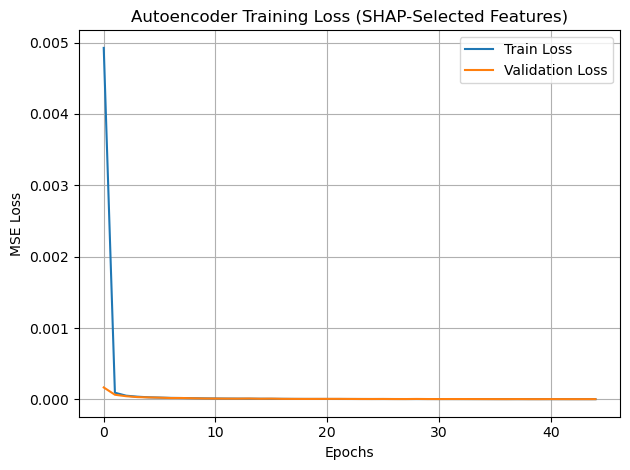

In [11]:
# Plot Training vs Validation Loss 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss (SHAP-Selected Features)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(model_dir / "autoencoder_selected_loss_curve.png")
plt.show()

In [12]:
# Save Bottleneck Encoder 
encoder = Model(inputs=input_layer, outputs=bottleneck)
encoder.save(model_dir / "autoencoder_encoder_selected.keras")